# In vivo recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your recordings in the "data/13-In_vivo" folder

In [2]:
data_folder = "data/13-In_vivo"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.h5")
data_files.sort()
data_files

Folders:
Files:


['data/13-In_vivo/mp10_2025-06-18_0001.h5']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
data_file = 'data/13-In_vivo/mp10_2025-06-18_0001.h5'

Now we can load the file and plot the raw data:

Trace('mp10_2025-06-18_0001.h5')
Data points: 11,729,360
Duration: 586.468 s
Sampling rate: 20000 Hz
Sampling interval: 0.050 ms
Available channels: Current, Voltage


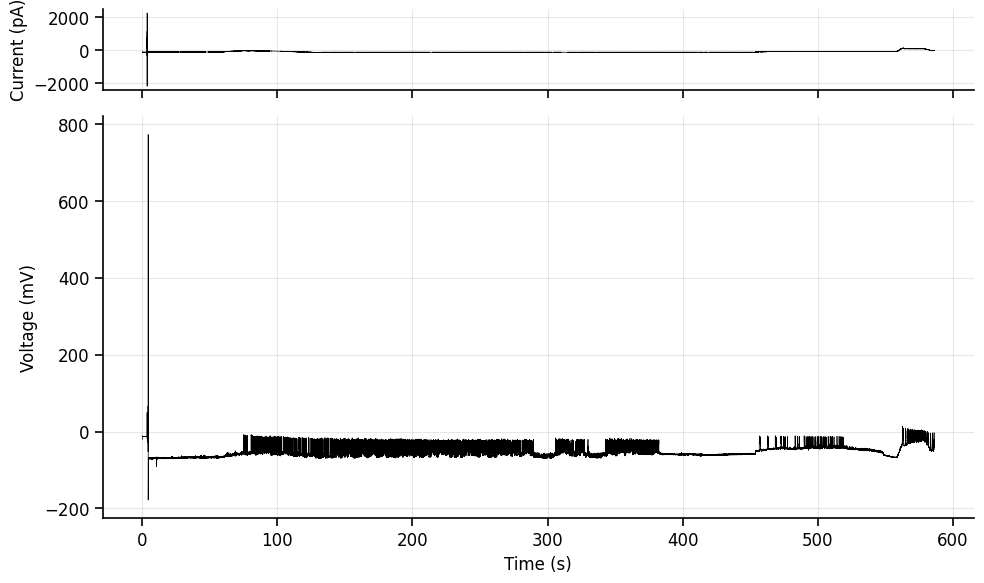

In [5]:
# Load with custom scaling and separate sweeps
traces = Trace.from_wavesurfer_h5_file(data_file, 
                                       voltage_scaling=0.1,
                                       current_scaling=1)
print(traces)
traces = traces.resample(sampling_frequency=10000)

time_units = 's' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
# %matplotlib widget
ax = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=[1, 5])
plt.show()

## 2. Signal processing

### First let's crop out the data we want to analyze (get rid of the initial portion before the recording starts)

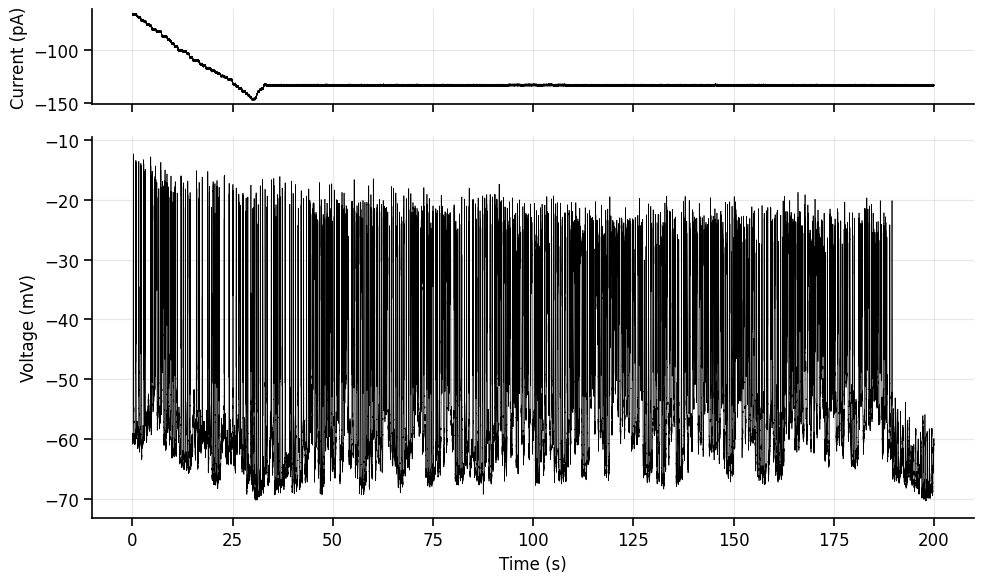

In [6]:
start_time = 100
end_time= 300

# ----------------------------------------------------------------------------------------------------------------
traces = traces.crop(timepoint=start_time, timepoint_2=end_time, time_units=time_units)

%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=[1, 4])
plt.show()


### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

In [7]:
subtract_baseline = False   # Subtract baseline to measure the current relative to the baseline (just before the voltage step)
linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
trend = None
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces, trend_dict = filtered_traces.detrend(detrend_type='linear', num_segments=1, return_trend=True)
    trend = trend_dict['voltage_trend']

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    filtered_traces.voltage_data = filtered_traces.voltage_data - np.median(filtered_traces.voltage_data)

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('Raw data', y=0.98)
    if trend is not None:   
        ax.plot(traces.time, trend, 'r', linewidth=2)
    ax.set_ylim(bottom=-200)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('After filtering', y=0.98)
    ax.set_ylim(bottom=-200)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [8]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

## 3. Measure firing rate to get FI curve

In [9]:
spike_results = traces.analyze_action_potentials(min_spike_amplitude=25.0, 
                                                max_width=25.0, 
                                                min_ISI=6, 
                                                headstage=0, 
                                                sweep=None, # None means all sweeps
                                                return_dict=True,
                                                time_units='ms')

spike_results

{'spike_times': array([   229.5,    238.7,    246. , ..., 188984.1, 188995. , 189509.8]),
 'threshold_voltages': array([-56.2033, -53.576 , -48.7259, ..., -52.0713, -50.0393, -51.4631]),
 'peak_voltages': array([-16.5268, -12.6774, -12.6774, ..., -24.184 , -24.184 , -23.8609]),
 'spike_amplitudes': array([39.6765, 40.8986, 36.0485, ..., 27.8874, 25.8553, 27.6022]),
 'spike_widths': array([19.3, 22.6, 14.5, ..., 15. ,  3.8, 13.6]),
 'peak_times': array([   247. ,    257.6,    257.6, ..., 188996.4, 188996.4, 189520.4])}

Number of events: 1058
Total area above threshold: 859.19
Individual event areas: ['1.32', '-0.00', '2.02', '-0.00', '-0.00', '0.82', '2.25', '0.13', '2.91', '-0.00', '2.45', '1.17', '-0.00', '0.32', '0.00', '-0.00', '0.00', '0.00', '3.37', '0.00', '0.13', '0.00', '0.00', '0.00', '0.00', '-0.00', '-0.00', '0.00', '0.00', '0.00', '-0.00', '10.45', '0.12', '0.00', '0.00', '0.10', '1.88', '7.38', '-0.00', '2.56', '-0.00', '2.20', '-0.00', '0.10', '-0.00', '0.11', '0.00', '0.14', '-0.00', '0.00', '-0.00', '4.09', '0.10', '-0.00', '0.00', '0.00', '0.00', '-0.00', '0.01', '0.00', '0.00', '0.17', '0.00', '0.00', '0.00', '2.35', '0.00', '0.00', '0.11', '-0.00', '1.91', '1.79', '-0.00', '0.47', '-0.00', '1.21', '0.00', '0.00', '0.00', '0.10', '0.10', '0.86', '-0.00', '0.00', '-0.00', '0.12', '-0.00', '0.00', '0.08', '0.09', '0.00', '0.59', '0.84', '0.08', '0.00', '0.00', '0.00', '1.59', '0.08', '0.06', '-0.00', '0.00', '0.00', '0.63', '0.06', '-0.00', '0.37', '0.08', '1.06', '0.08', '-0.00', '0

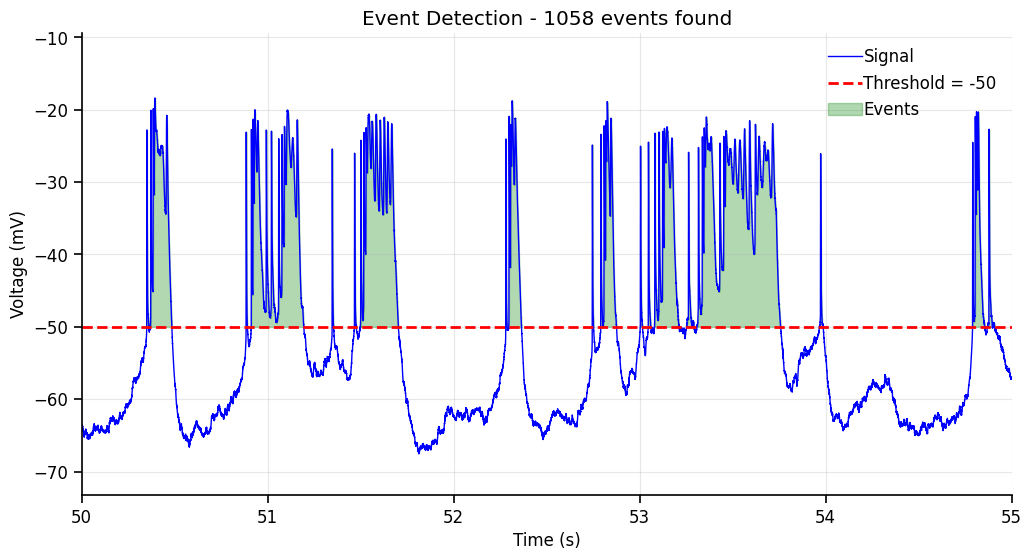

In [10]:
%matplotlib inline
threshold = -50
results, ax = analyze_threshold_events(traces.time, traces.voltage_data, threshold=threshold, plot=True, xlim=(50,55))

print(f"Number of events: {results['num_events']}")
print(f"Total area above threshold: {results['total_area']:.2f}")
print(f"Individual event areas: {[f'{area:.2f}' for area in results['event_areas']]}")
print(f"Event durations: {[f'{dur:.3f}' for dur in results['event_durations']]}")

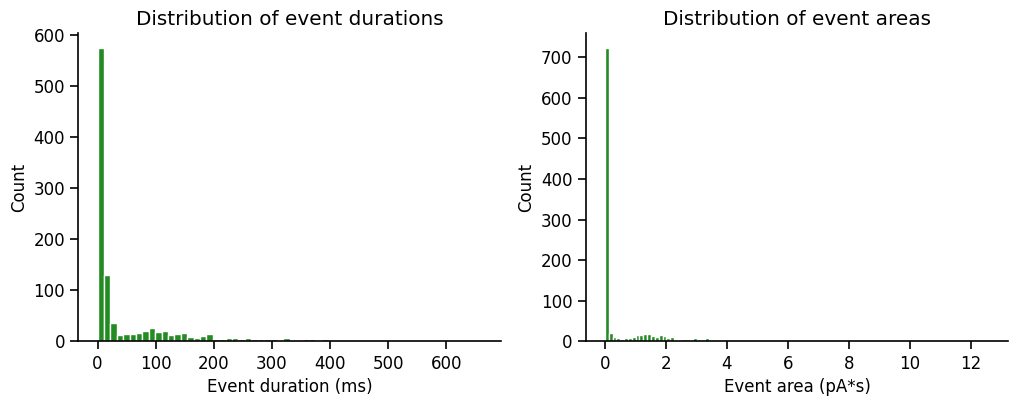

In [11]:
event_durations = np.array(results['event_durations'])*1000
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].hist(event_durations, bins=60, color='forestgreen', edgecolor='white')
ax[0].set_xlabel('Event duration (ms)')
ax[0].set_ylabel('Count')
# ax[0].set_yscale('log')
ax[0].set_title('Distribution of event durations')

ax[1].hist(results['event_areas'], bins=100, color='forestgreen', edgecolor='white')
ax[1].set_xlabel('Event area (pA*s)')
ax[1].set_ylabel('Count')
# ax[1].set_xlim(0, 16)
# ax[1].set_yscale('log')
ax[1].set_title('Distribution of event areas')
plt.show()

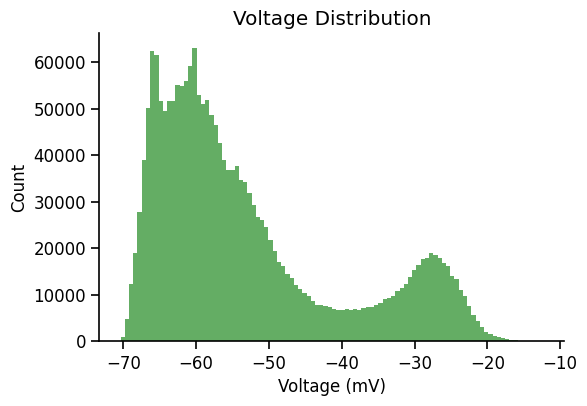

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(traces.voltage_data, bins=100, color='forestgreen', alpha=0.7)
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Count')
ax.set_title('Voltage Distribution')
plt.show()

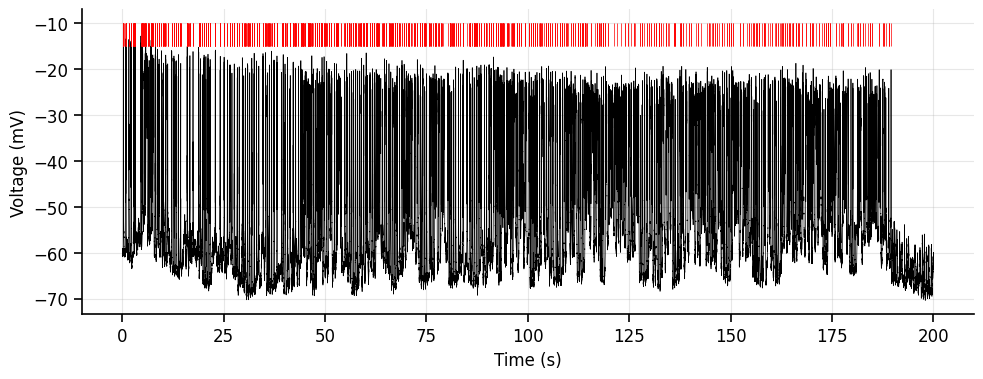

In [13]:
spike_times = spike_results['spike_times'] / 1000
# y_axis_range = (-0, 100)

%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=False)
ax.vlines(spike_times, -15, -10, color='r', linewidth=0.5)
# ax.set_ylim(y_axis_range)
# ax.set_xlim(220, 222)
# ax.set_xlim(149, 150)
plt.show()


Spike Property Summary:
--------------------------------------------------
Total spikes analyzed: 1341

Peak Voltages (mV):
  Mean ± SD: -22.6 ± 3.7
  Range: [-30.1, -12.3]

Spike Amplitudes (mV):
  Mean ± SD: 29.5 ± 3.1
  Range: [25.0, 40.9]

Spike Widths (ms):
  Mean ± SD: 14.94 ± 6.74
  Range: [2.20, 24.90]


(<Figure size 1200x400 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Peak Voltages'}, xlabel='Peak Voltages (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Amplitudes'}, xlabel='Spike Amplitudes (mV)', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Spike Widths'}, xlabel='Spike Widths (ms)', ylabel='Count'>],
       dtype=object),
 {'peak_voltages': {'mean': -22.63457673940872,
   'std': 3.7121116934560185,
   'min': -30.092273511012262,
   'max': -12.325218142641717,
   'n': 1341},
  'spike_amplitudes': {'mean': 29.470640061935296,
   'std': 3.070791313278282,
   'min': 25.005113238663135,
   'max': 40.898576751571106,
   'n': 1341},
  'spike_widths': {'mean': 14.935570469798659,
   'std': 6.738551663004582,
   'min': 2.2,
   'max': 24.900000000000002,
   'n': 1341}})

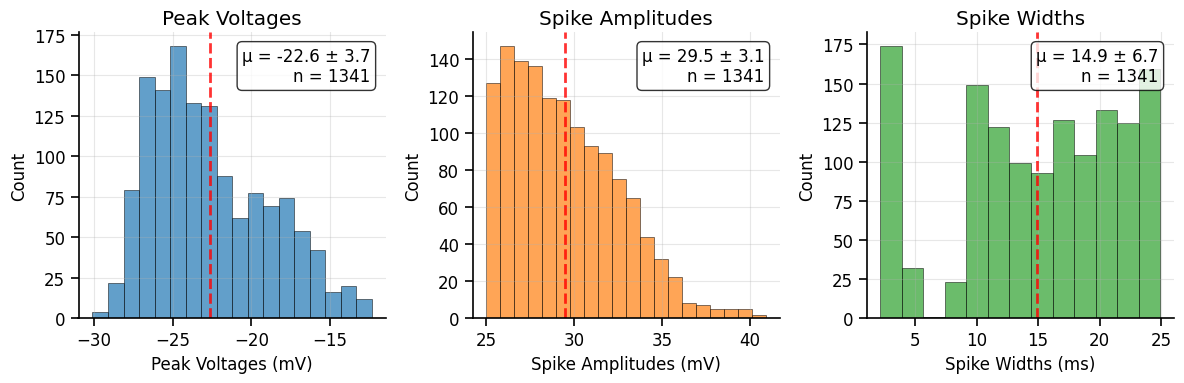

In [14]:
%matplotlib inline
plot_spike_histograms(spike_results)

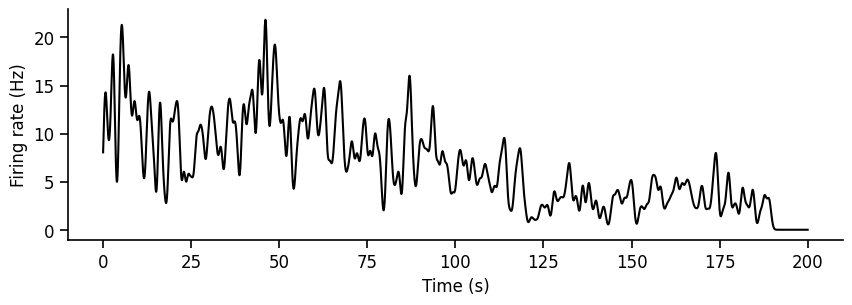

In [15]:
duration = traces.total_time
sampling_rate = traces.sampling_rate
time, firing_rate = fast_firing_rate(spike_times, duration, sampling_rate, sigma_ms=sampling_rate/20)

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(time,firing_rate, color='k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Firing rate (Hz)')
plt.show()